**python与numpy**格式

In [1]:
import numpy as np
import json
# 读入训练数据
datafile = './housing.data' 
data = np.fromfile(datafile, sep=' ')

In [2]:
feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE','DIS',  'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
feature_num = len(feature_names)
data = data.reshape([data.shape[0] // feature_num, feature_num])

In [9]:
ratio = 0.8
offset = int(data.shape[0] * ratio)
training_data = data[:offset]
test_data=data[offset:]
maximums, minimums, avgs = \
                     training_data.max(axis=0), \
                     training_data.min(axis=0), \
     training_data.sum(axis=0) / training_data.shape[0]
# 对数据进行归一化处理
for i in range(feature_num):
    #print(maximums[i], minimums[i], avgs[i])
    data[:, i] = (data[:, i] - avgs[i]) / (maximums[i] - minimums[i])

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
x = training_data[:, 0:-1]
y = training_data[:, [-1]]
test_x=test_data[:,0:-1]
test_y=test_data[:,[-1]]

class Network(nn.Module):
    def __init__(self):
        super( Network, self ).__init__() 
        self.liner1=nn.Linear(13,6)
        self.liner2=nn.Linear(6,1)
    def forward(self, x):
        out = F.relu(self.liner1(x))
        out = self.liner2(out)
        return out

In [53]:
net = Network()
y_preds=[]
labels_list=[]
train_nums=[]
train_costs=[]
train_num = 0
min_cost = 30000
batch_size=20
save_path='./'
loss_function = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
for epoch in range(500):
    np.random.shuffle(x)
    mini_batches = [x[k:k+batch_size] for k in range(0,len(x),batch_size)]
    for batch_id,data in enumerate(mini_batches):
        data= torch.tensor(x).type(torch.FloatTensor)
        target = torch.tensor(y).type(torch.LongTensor)
        out=net(data)
        loss = loss_function(out, target.squeeze())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_id%30 == 0 and epoch%50 == 0:
            print("Pass:%d,Cost:%0.5f"%(epoch, loss))
            train_num = train_num + batch_size
            train_nums.append(train_num)
            train_costs.append(loss)

            if loss < min_cost:
                min_cost = loss
                save_name = save_path+'best_acc.pdparams'
                torch.save(net.state_dict(), save_name)

INFER_BATCH_SIZE = 100
infer_features_np = np.array([data[:13] for data in test_data]).astype("float32")
infer_labels_np = np.array([data[-1] for data in test_data]).astype("float32")
infer_features = torch.tensor(infer_features_np)
infer_labels = torch.tensor(infer_labels_np)
fetch_list = net(infer_features)

sum_cost = 0
for i in range(INFER_BATCH_SIZE):
    infer_result = fetch_list[i][0]
    ground_truth = infer_labels[i]
    if i % 10 == 0:
        print("No.%d: infer result is %.2f,ground truth is %.2f" % (i, infer_result, ground_truth))
    cost = torch.pow(infer_result - ground_truth, 2)
    sum_cost += cost
mean_loss = sum_cost / INFER_BATCH_SIZE
print("Mean loss is:", mean_loss.detach().numpy())

Pass:0,Cost:0.00000
Pass:50,Cost:0.00000
Pass:100,Cost:0.00000
Pass:150,Cost:0.00000
Pass:200,Cost:0.00000
Pass:250,Cost:0.00000
Pass:300,Cost:0.00000
Pass:350,Cost:0.00000
Pass:400,Cost:0.00000
Pass:450,Cost:0.00000
No.0: infer result is -0.27,ground truth is -0.35
No.10: infer result is -0.26,ground truth is -0.38
No.20: infer result is -0.26,ground truth is -0.28
No.30: infer result is -0.25,ground truth is -0.28
No.40: infer result is -0.26,ground truth is -0.30
No.50: infer result is -0.26,ground truth is -0.21
No.60: infer result is -0.26,ground truth is -0.06
No.70: infer result is -0.26,ground truth is -0.23
No.80: infer result is -0.27,ground truth is -0.08
No.90: infer result is -0.24,ground truth is 0.01
Mean loss is: 0.017520446


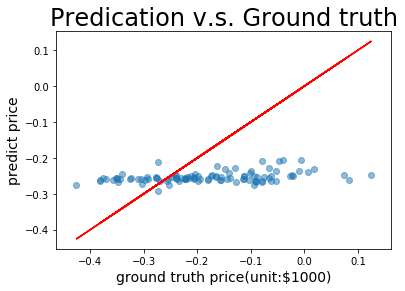

In [54]:
import matplotlib.pyplot as plt
def plot_pred_ground(pred, ground):
    plt.figure()   
    plt.title("Predication v.s. Ground truth", fontsize=24)
    plt.xlabel("ground truth price(unit:$1000)", fontsize=14)
    plt.ylabel("predict price", fontsize=14)
    plt.scatter(ground, pred, alpha=0.5)  #  scatter:散点图,alpha:"透明度"
    plt.plot(ground, ground, c='red')
    plt.show()
plot_pred_ground(fetch_list.detach().numpy(), infer_labels_np)